In [1]:
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

# Process the training data

In [4]:
loss_data_dir = join(getcwd(), "loss_data", "train")

kl_loss_path = join(loss_data_dir, "run-.-tag-kl_loss.csv")
recon_loss_path = join(loss_data_dir, "run-.-tag-loss.csv")
general_loss_path = join(loss_data_dir, "run-.-tag-recon_loss.csv")

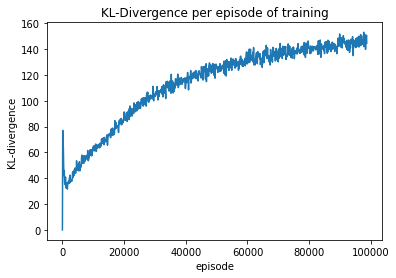

In [19]:
kl_loss = np.genfromtxt(kl_loss_path, skip_header=1, delimiter=",")
plt.plot(kl_loss[:,1], kl_loss[:,2])
plt.title("KL-Divergence per episode of training")
plt.ylabel("KL-divergence")
plt.xlabel("episode")
plt.savefig(join(loss_data_dir, "kl_plot.png"))
plt.show()


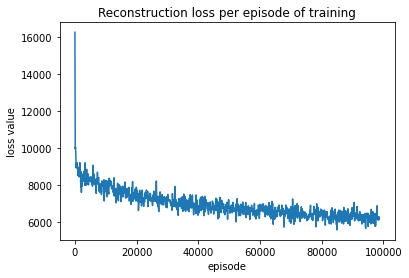

In [20]:
recon_loss = np.genfromtxt(recon_loss_path, skip_header=1, delimiter=",")
plt.plot(recon_loss[:,1], recon_loss[:,2])
plt.title("Reconstruction loss per episode of training")
plt.ylabel("loss value")
plt.xlabel("episode")
plt.savefig(join(loss_data_dir, "recon_plot.png"))
plt.show()

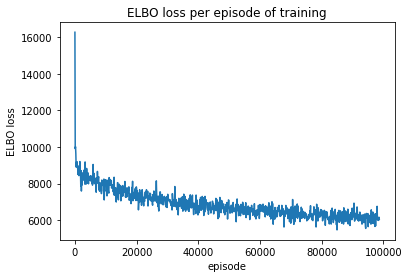

In [21]:
general_loss = np.genfromtxt(general_loss_path, skip_header=1, delimiter=",")
plt.plot(general_loss[:,1], general_loss[:,2])
plt.title("ELBO loss per episode of training")
plt.ylabel("ELBO loss")
plt.xlabel("episode")
plt.savefig(join(loss_data_dir, "elbo_plot.png"))
plt.show()

# Process the validation data

In [14]:
data_dir = join(getcwd(), "loss_data", "test")

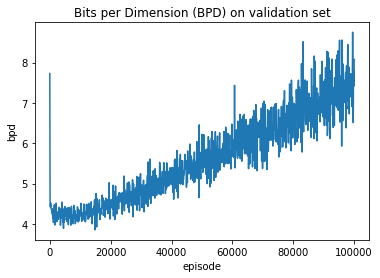

In [16]:
# Plot the Bits per Dimension on the validation set during training
bpd_loss_val = np.genfromtxt(join(data_dir, "bpd-loss.csv"), skip_header=1, delimiter=",")
plt.plot(bpd_loss_val[:,1], bpd_loss_val[:,2])
plt.title("Bits per Dimension (BPD) on validation set")
plt.ylabel("bpd")
plt.xlabel("episode")
plt.savefig(join(data_dir, "bpd_plot.png") )
plt.show()

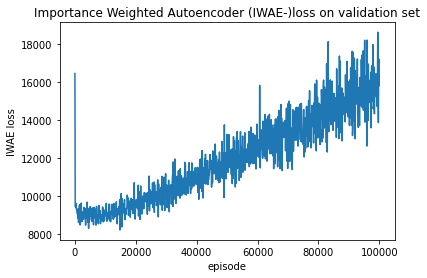

In [18]:
# Plot the IWAE loss on the validation set during training
iwae_loss_val = np.genfromtxt(join(data_dir, "total-loss.csv"), skip_header=1, delimiter=",")
plt.plot(iwae_loss_val[:,1], iwae_loss_val[:,2])
plt.title("Importance Weighted Autoencoder (IWAE-)loss on validation set")
plt.ylabel("IWAE loss")
plt.xlabel("episode")
plt.savefig(join(data_dir, "iwae_plot.png") )
plt.show()

In [62]:
import torch as t
import math
from torch import nn
from torch.nn import DataParallel
from torchvision import transforms, datasets

from dml import DiscretizedMixtureLogitsDistribution
from residual import Residual
from vnca import VNCA
from train import train
from data import PokemonIMG
from loss import elbo

In [63]:
z_size = 256
nca_hid = 128
n_mixtures = 1
batch_size = 32
dmg_size = 16
p_update = 1.0
min_steps, max_steps = 64, 128

filter_size = 5
pad = filter_size // 2
encoder_hid = 32
h = w = 32
n_channels = 3


def state_to_dist(state):
    return DiscretizedMixtureLogitsDistribution(n_mixtures, state[:, :n_mixtures * 10, :, :])


encoder = nn.Sequential(
    nn.Conv2d(n_channels, encoder_hid * 2 ** 0, filter_size, padding=pad), nn.ELU(),  # (bs, 32, h, w)
    nn.Conv2d(encoder_hid * 2 ** 0, encoder_hid * 2 ** 1, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 64, h//2, w//2)
    nn.Conv2d(encoder_hid * 2 ** 1, encoder_hid * 2 ** 2, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 128, h//4, w//4)
    nn.Conv2d(encoder_hid * 2 ** 2, encoder_hid * 2 ** 3, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 256, h//8, w//8)
    nn.Conv2d(encoder_hid * 2 ** 3, encoder_hid * 2 ** 4, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 512, h//16, w//16),
    nn.Flatten(),  # (bs, 512*h//16*w//16)
    nn.Linear(encoder_hid * (2 ** 4) * h // 16 * w // 16, 2 * z_size),
)

update_net = nn.Sequential(
    nn.Conv2d(z_size, nca_hid, 3, padding=1),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    nn.Conv2d(nca_hid, z_size, 1)
)
update_net[-1].weight.data.fill_(0.0)
update_net[-1].bias.data.fill_(0.0)

# encoder = DataParallel(encoder)
# update_net = DataParallel(update_net)

dset = PokemonIMG()

num_samples = len(dset)
train_split = 0.7
val_split = 0.2
test_split = 0.1

num_train = math.floor(num_samples*train_split)
num_val = math.floor(num_samples*val_split)
num_test = math.floor(num_samples*test_split)
num_test = num_test + (num_samples - num_train - num_val - num_test)

train_set, val_set, test_set = t.utils.data.random_split(dset, [num_train, num_val, num_test])

vnca = VNCA(h, w, n_channels, z_size, encoder, update_net, train_set, val_set, test_set, state_to_dist, batch_size, dmg_size, p_update, min_steps, max_steps)


VNCA(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ELU(alpha=1.0)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): ELU(alpha=1.0)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=512, bias=True)
  )
  (nca): NCA(
    (update_net): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Residual(
        (delegate): Sequential(
          (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): ELU(alpha=1.0)
          (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
 

In [64]:
os.listdir(os.path.join(os.getcwd(), "..", "..", "vnca", "tasks", "pokemon"))

['best',
 'data.py',
 'data_store',
 'latest',
 'main copy.py',
 'main.py',
 'TBtest',
 'TBtrain',
 'test.ipynb',
 '__pycache__']

In [65]:
param_path = os.path.join(os.getcwd(), "..", "..", "vnca", "tasks", "pokemon", "latest")

In [66]:
vnca.load(param_path)

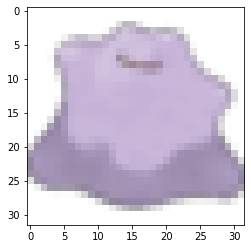

In [67]:
plt.imshow(dset.find("132.png")[0].permute(1, 2, 0))

In [14]:
test_img = dset.find("132.png")[0]
print(test_img.shape)
test_img = test_img.unsqueeze(0)
print(test_img.shape)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


In [15]:
loss, z, p_x_given_z, recon_loss, kl_loss, states = vnca.forward(test_img, 1, elbo)

shape of z torch.Size([1, 1, 256])
reshape 1: torch.Size([1, 256])
reshape 2: torch.Size([1, 256, 1])
reshape 3: torch.Size([1, 256, 1, 1])
reshape 4: torch.Size([1, 256, 32, 32])
shape of the state to propagate torch.Size([1, 256, 32, 32])


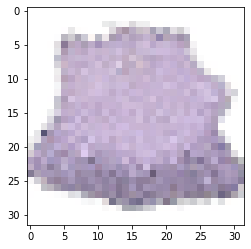

In [16]:
#img = vnca.to_rgb(states[-1].cpu().detach())
#print(img.shape)
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[0].squeeze().permute(1,2,0).cpu().detach()) 

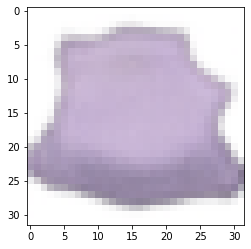

In [17]:
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[1].squeeze().permute(1,2,0).cpu().detach()) 

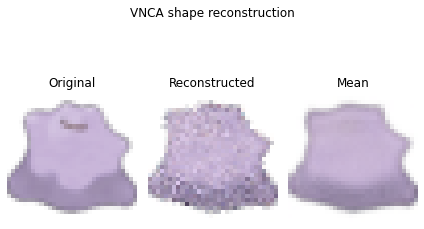

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('VNCA shape reconstruction')
ax1.imshow(dset.find("132.png")[0].permute(1, 2, 0))
ax1.axis('off')
ax1.title.set_text("Original")
ax2.imshow(vnca.to_rgb(states[-1].cpu().detach())[0].squeeze().permute(1,2,0).cpu().detach())
ax2.axis('off')
ax2.title.set_text("Reconstructed")
ax3.imshow(vnca.to_rgb(states[-1].cpu().detach())[1].squeeze().permute(1,2,0).cpu().detach())
ax3.axis('off')
ax3.title.set_text("Mean")
fig.tight_layout()

In [22]:
samples = vnca.p_z.sample((8,)).view(8, -1, 1, 1).expand(8, -1, vnca.h, vnca.w).to(vnca.device)
states = vnca.decode(samples)
samples, samples_means = vnca.to_rgb(states[-1])

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [23]:
print(samples.shape)

torch.Size([8, 3, 32, 32])


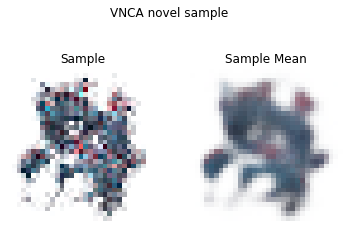

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('VNCA novel sample')
ax1.imshow(samples[0].permute(1, 2, 0).cpu().detach())
ax1.axis('off')
ax1.title.set_text("Sample")
ax2.imshow(samples_means[0].permute(1,2,0).cpu().detach())
ax2.axis('off')
ax2.title.set_text("Sample Mean")

In [39]:
from skimage import io
from PIL import Image
from torchvision import transforms

In [69]:
def to_alpha(x):
  return t.clip(x[3:4,...], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[:3,...], to_alpha(x)
  return 1.0-a+rgb

In [71]:
img_name = os.path.join(os.getcwd(), "pikachu2.png")
print(io.imread(img_name).shape)
image = dset.transform(Image.fromarray(io.imread(img_name)))
image[:3,...] *= image[3:,...]
print(image.shape)
image = to_rgb(image)
print(image.shape)

(854, 1138, 4)
torch.Size([4, 32, 32])
torch.Size([3, 32, 32])


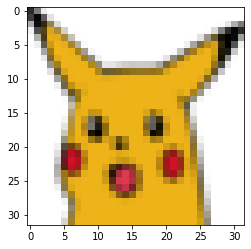

In [72]:
plt.imshow(image.permute(1, 2, 0))

In [73]:
test_img = image.unsqueeze(0)

In [74]:
loss, z, p_x_given_z, recon_loss, kl_loss, states = vnca.forward(test_img, 1, elbo)

shape of z torch.Size([1, 1, 256])
reshape 1: torch.Size([1, 256])
reshape 2: torch.Size([1, 256, 1])
reshape 3: torch.Size([1, 256, 1, 1])
reshape 4: torch.Size([1, 256, 32, 32])
shape of the state to propagate torch.Size([1, 256, 32, 32])


c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


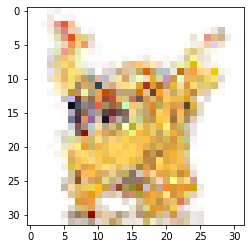

In [75]:
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[0].squeeze().permute(1,2,0).cpu().detach()) 

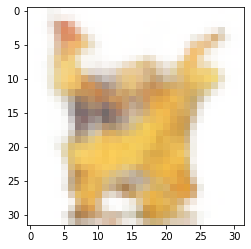

In [76]:
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[1].squeeze().permute(1,2,0).cpu().detach()) 

In [79]:
img_name = os.path.join(os.getcwd(), "pikachu3.png")
print(io.imread(img_name).shape)
image = dset.transform(Image.fromarray(io.imread(img_name)))
image[:3,...] *= image[3:,...]
print(image.shape)
image = to_rgb(image)
print(image.shape)

(223, 226, 4)
torch.Size([4, 32, 32])
torch.Size([3, 32, 32])


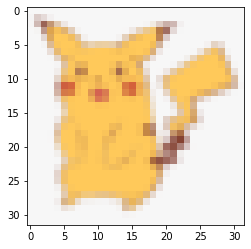

In [80]:
plt.imshow(image.permute(1, 2, 0))

In [81]:
test_img = image.unsqueeze(0)

In [82]:
loss, z, p_x_given_z, recon_loss, kl_loss, states = vnca.forward(test_img, 1, elbo)

shape of z torch.Size([1, 1, 256])
reshape 1: torch.Size([1, 256])
reshape 2: torch.Size([1, 256, 1])
reshape 3: torch.Size([1, 256, 1, 1])
reshape 4: torch.Size([1, 256, 32, 32])
shape of the state to propagate torch.Size([1, 256, 32, 32])


c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


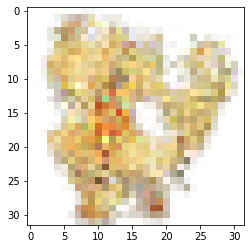

In [83]:
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[0].squeeze().permute(1,2,0).cpu().detach()) 

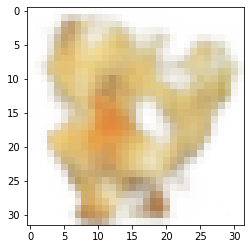

In [84]:
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[1].squeeze().permute(1,2,0).cpu().detach()) 

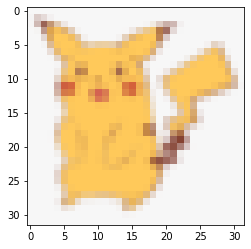

In [85]:
plt.imshow(test_img[0].permute(1, 2, 0))